# Explorind the titanic dataset

## Introduction

Since I don't have a lot of ideas let's see what other people have done for this dataset. The following are key points form other peoples kernels.

---

### [Megan Risdal](https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic)

*Feature engineering*
 - Break families into 3 groups (plot family size vs survival - barplot)
 - Separate the passangers with respect to their decs (from the Cabin variable)
 - Child and mother bins (plot age histogram + survival)

*Implanting missing data*
 - Given the small data set do not delete
 - Implant missing Embarked data based on passenger class and fare (replace the NA values with 'C')
 - Implant missing Fare value (maybe use median)
 - Implant age using recursive partitioning for regression model (Look up mice implantation)
 
*Model*
 - Random forrest
 - Show model error (plot)
 - Plot variable importance
 
*Notes*
 - Nice format (structure) of the kernel
 - She has index, which is nice


### [swamysm](https://www.kaggle.com/swamysm/beginners-titanic)

 - Interesting conclusion - 
 ```When I submit the predicted survival data from various models that built in the course to Kaggle competion, i have got approximately the same score. Now I realize that why data scientist used to spend most of their time into feature engineering and exploratory analysis compare to actual model building. Model that we are using is definitely important, however more than that understanding our data and feature engineering is crucial.```


### [Anisotropic](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)

```
Method of ensembling (combining) base learning models, in particular the variant of ensembling known as Stacking
```

*Feature engineering*
 - Feature that tells whether a passenger had a cabin on the Titanic
 - FamilySize as a combination of SibSp and Parch
 - Feature IsAlone from FamilySize
 - Random Age based on mean and std

*Visualization*
 - Pearson Correlation Heatmap
 - Takeaway from the Plots

*Model (Ensembling & Stacking)*
 - RandomForestClassifier
 - AdaBoostClassifier
 - GradientBoostingClassifier
 - ExtraTreesClassifier
 - SVC
 - KFold


### General notes
 - A lot of people use RandomForrest even though it is known to overfit
 
 ---
 
## Goals
 - Construct pipeline that does the preprocessing and learning
 - Get higher than `2793/8677` in kaggle
 
 ---
 
## Plan
 - Apply regression to fill the missing age values
 - Input the median value for the orther missing feature values
 - One-hot encode Gender and Embarked
 - Apply binning to age
 - Visualize different features against survival rate
 - Visualize confusion matrix
 - Construct pipeline for feature mapping
 - Try RandomForrest, SVM and Logistic regression
 - Vizualize model error and variable importance
 - Grid search for the best hyper-parameters
 - Apply model on test data and submit
 - Profit

## Loading the necessary scripts and the data

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import FeatureUnion

from IPython.display import display

%matplotlib inline
sns.set()

In [167]:
# Loading the data
train = pd.read_csv('data/titanic-train.csv', index_col='PassengerId')
test = pd.read_csv('data/titanic-test.csv', index_col='PassengerId')

full_data = [train, test]

# Lets have a look at the data
train.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Getting to know the data

In [168]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Some of the **age** rows are empty, we weould need to **implant** some data there.

In [169]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Lets implant the expected value of the age on the empty rows

## Baseline model

In [170]:
X = train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
y = train['Survived']

X['Age'][X['Age'].isnull()] = X['Age'].mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8, stratify=y)

In [171]:
lr_mode = LogisticRegression().fit(X_train, y_train)

rf_model = RandomForestClassifier().fit(X_train, y_train)

svc_model = SVC(C=1).fit(X_train, y_train)

print("logistic recression train score:", lr_mode.score(X_train, y_train))
print("logistic recression test score: ", lr_mode.score(X_test, y_test))
print()
print("random forest train score:", rf_model.score(X_train, y_train))
print("random forest recression test score: ", rf_model.score(X_test, y_test))
print()
print("support vector classifier score:", svc_model.score(X_train, y_train))
print("support vector classifier score: ", svc_model.score(X_test, y_test))

logistic recression train score: 0.693113772455
logistic recression test score:  0.744394618834

random forest train score: 0.929640718563
random forest recression test score:  0.654708520179

support vector classifier score: 0.862275449102
support vector classifier score:  0.659192825112


A lot of overfitting on the svm and random forrest models.

# Feature engineering

In [226]:
train['Embarked'][train['Embarked'].isnull()] = train['Embarked'].mode()
train = train.combine_first(pd.get_dummies(train['Embarked'], prefix='Embarked'))

train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

train['IsAlone'] = (train['FamilySize'] == 1).apply(int)

train['Sex'] = train['Sex'].apply(lambda x: x[0])
train = train.combine_first(pd.get_dummies(train['Sex'], prefix='Gender'))

train['Cabin'][train['Cabin'].isnull()] = 'N'
train['Cabin'] = train['Cabin'].apply(lambda x: x[0])
train = train.combine_first(pd.get_dummies(train['Cabin'], prefix='Cabin'))

X_age = train.copy().drop(['Age', 'Cabin', 'Embarked', 'Name', 'Sex', 'Ticket'], axis=1)
y_age = train.copy()['Age']
X_age_train = X_age[~y_age.isnull()]
y_age_train = y_age[~y_age.isnull()]
X_age_test = X_age[y_age.isnull()]

age_implant_model = LinearRegression()
age_implant_model.fit(X_age_train, y_age_train)

scores = cross_val_score(age_implant_model, X_age_train, y_age_train, cv=5)
print('Age inplant model score: '+ str(scores))
# The score is low I guess but its better than nothing :D 
# Its also better than the constant model with score of 0

y_age[y_age.isnull()] = age_implant_model.predict(X_age_test)
train['BetterAge'] = y_age_test

cols_to_remve = ['Age', 'Cabin', 'Embarked', 'Name', 'Sex', 'Ticket', 'SibSp', 'Parch']

mapped_train = train.drop(cols_to_remve, axis=1)
mapped_train.describe()

Age inplant model score: [ 1.  1.  1.  1.  1.]


,BetterAge,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Fare,Gender_f,Gender_m,IsAlone,Pclass,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.327605,0.016835,0.052750,0.066218,0.037037,0.035915,0.014590,0.004489,0.771044,0.001122,0.188552,0.086420,0.722783,1.904602,32.204208,0.352413,0.647587,0.602694,2.308642,0.383838
std,13.714879,0.128725,0.223659,0.248802,0.188959,0.186182,0.119973,0.066890,0.420397,0.033501,0.391372,0.281141,0.447876,1.613459,49.693429,0.477990,0.477990,0.489615,0.836071,0.486592
min,-5.265343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.910400,0.000000,0.000000,0.000000,2.000000,0.000000
50%,29.114832,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,14.454200,0.000000,1.000000,1.000000,3.000000,0.000000
75%,36.443835,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,31.000000,1.000000,1.000000,1.000000,3.000000,1.000000
max,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,512.329200,1.000000,1.000000,1.000000,3.000000,1.000000


It looks like we will need to scale BetterAge and Fare.

# Visualizing correlations

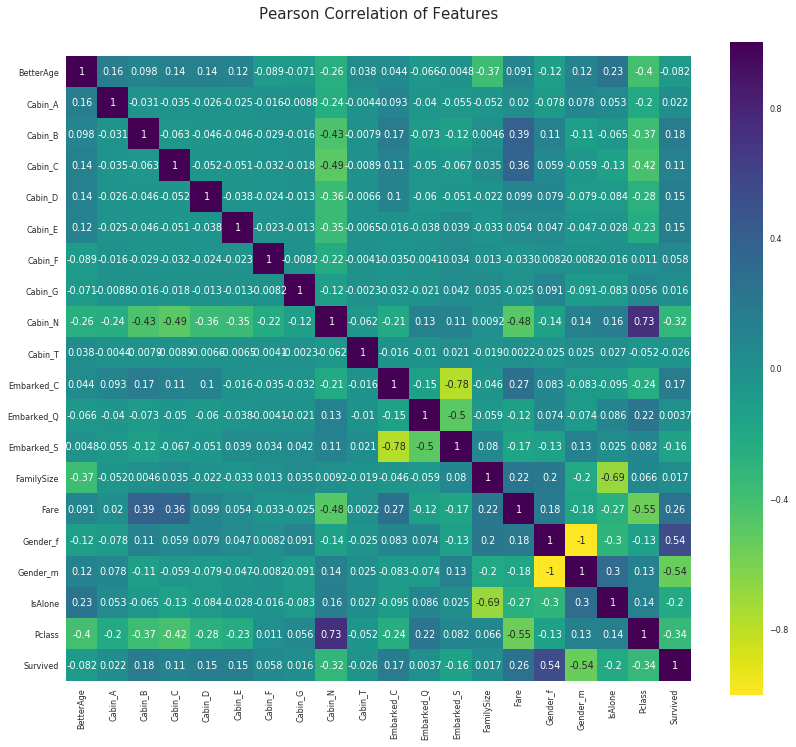

In [227]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.set(font_scale=0.8)
sns.heatmap(mapped_train.astype(float).corr(), square=True, annot=True, cmap=plt.cm.viridis_r)

In [229]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score


class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[[self.key]]
    
class StringImputer(TransformerMixin):
    def fit(self, X, *_):
        self.modes = X.mode().iloc[0]
        return self
        
    def transform(self, X, y=None):
        return X.fillna(self.modes)

model = Pipeline([
    ('union', FeatureUnion([
        ('age', Pipeline([
            ('select', ItemSelector('BetterAge')),
            ('scaler', StandardScaler()),
        ])),
        ('sibsp', Pipeline([
            ('select', ItemSelector('FamilySize')),
            ('scaler', StandardScaler()),
        ])),
        ('parch', Pipeline([
            ('select', ItemSelector('Fare')),
            ('scaler', StandardScaler()),
        ])),
    ])),
    ('svc', ())
])

scores = cross_val_score(model, mapped_train.drop(['Survived'], axis=1), mapped_train['Survived'], cv=5)
# scores = cross_val_score(model, train, train['Survived'], cv=5)
print(scores)
print(scores.mean())

[ 0.63128492  0.73184358  0.66853933  0.67977528  0.68361582]
0.679011783514
